In [1]:
!pip install transformers==4.28.0
import transformers
import seaborn as sns

In [2]:
#importing the necessary libraries
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from transformers import BertForSequenceClassification


In [3]:
print(torch.cuda.is_available())

True


In [4]:
from google.colab import drive
drive.mount('/content/drive')

파일ID = '19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD'
파일저장이름 = 'mbti_1.csv'

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt

print(파일저장이름+"을 정상적으로 가져왔습니다.")

import pandas as pd
data = pd.read_csv(파일저장이름, sep='\t')

#importing the dataset into a DataFrame
df = pd.read_csv('mbti_1.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-11-25 15:02:34--  https://docs.google.com/uc?export=download&confirm=&id=19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD
Resolving docs.google.com (docs.google.com)... 74.125.20.138, 74.125.20.100, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nv07c9r21p6l8r2vcdgp397d4gc9rbpn/1700924550000/17320300888472664624/*/19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD?e=download&uuid=8e51f399-13ec-4c29-adda-983d6e9795c3 [following]
--2023-11-25 15:02:37--  https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nv07c9r21p6l8r2vcdgp397d4gc9rbpn/1700924550000/17320300888472664624/*/19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD?e=download&uuid=8e51f399-13ec-4c29

In [5]:
#showing the first 5 rows of the dataset
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
#showing dataset infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [7]:
#showing the posts of the first user in the dataset
df.posts.values[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [8]:
#showing the number of users per personality type
df.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [9]:
#visualizing the number of users per personality type using a histogram
# plt.figure(figsize=(20,10))
# sns.countplot(df.type)
# plt.xlabel('Types count');

In [10]:
#removing URLs and punctuation from dataset
for index in df.index.values:
  df.posts.iloc[index] = ' '.join(df.posts.iloc[index].split('|||'))
  df.posts.iloc[index] = re.sub(r"http\S+","",df.posts.iloc[index])
  df.posts.iloc[index] = re.sub(r"[-/@.?!_,:;()|0-9]","",df.posts.iloc[index])
  df.posts.iloc[index] = ' '.join(df.posts.iloc[index].split('  '))
df.head(10)

"""
saving the clean dataset into a csv file
df.to_csv('mbti_clean_dataset.csv',index=False)
"""

"\nsaving the clean dataset into a csv file\ndf.to_csv('mbti_clean_dataset.csv',index=False)\n"

In [11]:
#identifying the different classes of users in the dataset
labels = df.type.unique()
labels

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [12]:
#mapping personality types with their numberical representation
labels = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
labels_ids = {
    'ISTJ': 0, 'ISFJ': 1, 'INFJ': 2, 'INTJ': 3,
    'ISTP': 4, 'ISFP': 5, 'INFP': 6, 'INTP': 7,
    'ESTP': 8, 'ESFP': 9, 'ENFP': 10, 'ENTP': 11,
    'ESTJ': 12, 'ESFJ': 13, 'ENFJ': 14, 'ENTJ': 15
}

In [13]:
#replacing each personality type with its numerical representation
df['label'] = df.type.replace(labels_ids)
df.head(10)

,type,posts,label
0,INFJ,' enfp and intj moments sportscenter not top ...,2
1,ENTP,'I'm finding the lack of me in these posts ver...,11
2,INTP,'Good one Of course to which I say I know th...,7
3,INTJ,'Dear INTP I enjoyed our conversation the oth...,3
4,ENTJ,'You're fired That's another silly misconcepti...,15
5,INTJ,' Science is not perfect No scientist claims t...,3
6,INFJ,'No I can't draw on my own nails haha Those we...,2
7,INTJ,'I tend to build up a collection of things on ...,3
8,INFJ,I'm not sure that's a good question The distin...,2
9,INTP,' I'm in this position where I have to actuall...,7


In [14]:
#Splitting the dataset into training (85% of the data) and test (15% of the data) sets
x_train, x_test, y_train, y_test = train_test_split(df.index.values, df.label.values, test_size=0.15, random_state=17, stratify=df.label.values)

In [15]:
#creating a new column "data_type"
df['data_type'] = ['not_set']*df.shape[0]

In [16]:
#identifying the rows belonging to both training and test sets
df.loc[x_train,'data_type'] = 'train'
df.loc[x_test,'data_type'] = 'test'

In [17]:
df.head(10)

,type,posts,label,data_type
0,INFJ,' enfp and intj moments sportscenter not top ...,2,train
1,ENTP,'I'm finding the lack of me in these posts ver...,11,train
2,INTP,'Good one Of course to which I say I know th...,7,train
3,INTJ,'Dear INTP I enjoyed our conversation the oth...,3,train
4,ENTJ,'You're fired That's another silly misconcepti...,15,train
5,INTJ,' Science is not perfect No scientist claims t...,3,train
6,INFJ,'No I can't draw on my own nails haha Those we...,2,train
7,INTJ,'I tend to build up a collection of things on ...,3,train
8,INFJ,I'm not sure that's a good question The distin...,2,train
9,INTP,' I'm in this position where I have to actuall...,7,train


In [18]:
#showing the amount of data reserved for training and test per personality type
df.groupby(['type','label','data_type']).count()

posts
type label data_type       
ENFJ 14    test          28
           train        162
ENFP 10    test         101
           train        574
ENTJ 15    test          35
           train        196
ENTP 11    test         103
           train        582
ESFJ 13    test           6
           train         36
ESFP 9     test           7
           train         41
ESTJ 12    test           6
           train         33
ESTP 8     test          13
           train         76
INFJ 2     test         221
           train       1249
INFP 6     test         275
           train       1557
INTJ 3     test         164
           train        927
INTP 7     test         196
           train       1108
ISFJ 1     test          25
           train        141
ISFP 5     test          41
           train        230
ISTJ 0     test          31
           train        174
ISTP 4     test          50
           train        287

In [19]:
#creating a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [20]:
#encoding the data using our tokenizer
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].posts.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].posts.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=512,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
#showing an example of data tokenized and encoded by BERT tokenizer
encoded_data_test

{'input_ids': tensor([[  101,  1005,  2115,  ...,  2052,  2079,   102],
        [  101,  1005,  2008,  ..., 10985,  5346,   102],
        [  101,  1005,  1045,  ...,  2295,  2130,   102],
        ...,
        [  101,  1005,  1045,  ...,  2711,  2017,   102],
        [  101,  1005,  2987,  ...,  2173,  2054,   102],
        [  101,  1005, 11814,  ...,  2000, 23870,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [22]:
#preparing inputs for BERT model
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

In [23]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)

In [24]:
dataset_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
dataset_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)
len(dataset_train)

7373

In [25]:
#creating a BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(labels_ids),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob=0.1,
                                                      hidden_dropout_prob=0.1)
model



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [27]:
#Defining the batch size
batch_size = 16
#less for limited hardware ressources. Example : 4

In [28]:
#creating dataloader to load the data while training
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_test = DataLoader(dataset_test,
                                   sampler=SequentialSampler(dataset_test),
                                   batch_size=batch_size)

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

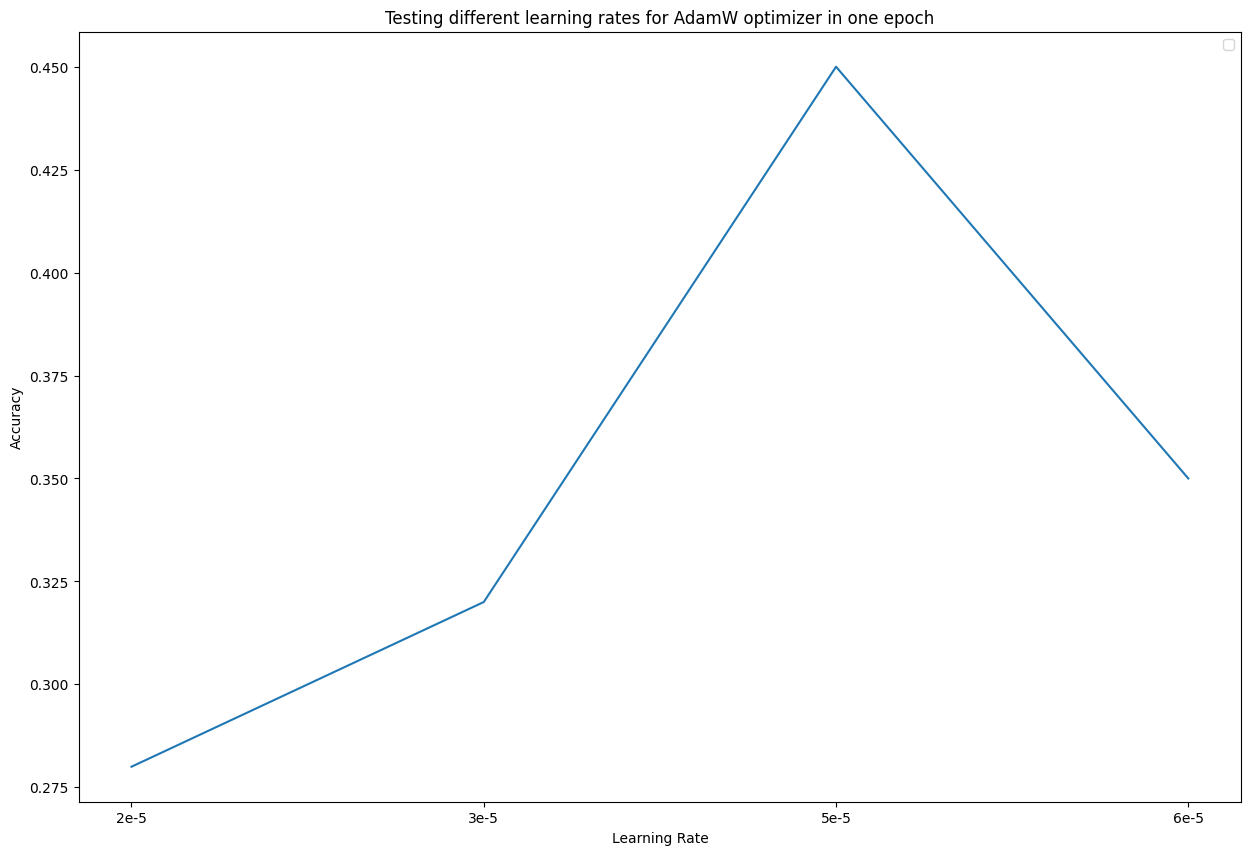

In [30]:
"""
Testing different learning rates for AdamW optimizer in one epoch
The following values of learning rates were tested on this code
Recommanded learning rate for BERT between 2e-5 and 5e-5
"""
learning_rate = ['2e-5','3e-5','5e-5','6e-5']
accuracy = [0.28,0.32,0.45,0.35]
plt.figure(figsize=(15,10))
plt.title('Testing different learning rates for AdamW optimizer in one epoch')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.legend()
plt.plot(learning_rate,accuracy)

In [31]:
#creating an AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)
#recommanded epsilon : 1e-8

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
#Defining the number of epochs
epochs = 10

In [33]:
#creating a scheduler to update the learning rate while training
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0.1,
                                            num_training_steps=len(dataloader_train)*epochs)

In [34]:
import numpy as np

In [35]:
from sklearn.metrics import f1_score

In [36]:
#Defining the global accuracy function
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [37]:
#Defining the accuracy per class function
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in labels_ids.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
    return preds_flat, labels_flat

In [38]:
#Defining the device on which we're going to run the code
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

True
cuda


In [39]:
#Defining the evaluation function to get predictions and true types
def evaluate(dataloader_test):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_test:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_test)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [40]:
#Training

import random
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
f1_score_history = []
f1_score_train_history = []
train_loss_history = []
train_test_history = []

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_test)
    tr_loss, predictions_train, true_vals_train = evaluate(dataloader_train)
    val_f1 = f1_score_func(predictions, true_vals)
    tr_f1 = f1_score_func(predictions_train, true_vals_train)
    f1_score_history.append(val_f1)
    f1_score_train_history.append(tr_f1)
    tqdm.write(f'Test loss: {val_loss}')
    train_test_history.append(val_loss)
    tqdm.write(f'F1 Score test (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.280985572591521
Test loss: 2.221530201958447
F1 Score test (Weighted): 0.1547016578638937


Epoch 2:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.9681802287277586
Test loss: 1.727575414064454
F1 Score test (Weighted): 0.4489732996888779


Epoch 3:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.5509046733767247
Test loss: 1.515292310133213
F1 Score test (Weighted): 0.5278191805619128


Epoch 4:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.277387952209812
Test loss: 1.4136059146101883
F1 Score test (Weighted): 0.5675387101772558


Epoch 5:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9976695946007644
Test loss: 1.5207425014274876
F1 Score test (Weighted): 0.573878102736034


Epoch 6:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.7660646131848048
Test loss: 1.6911741655047348
F1 Score test (Weighted): 0.5576719455354966


Epoch 7:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.5671322037043643
Test loss: 1.8003104518099529
F1 Score test (Weighted): 0.5585500095375483


Epoch 8:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.42459721593368077
Test loss: 1.971557929748442
F1 Score test (Weighted): 0.5493041787061786


Epoch 9:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.32931715687595453
Test loss: 2.1342631324035364
F1 Score test (Weighted): 0.5375516949988538


Epoch 10:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.2684186353043142
Test loss: 2.1550333078314616
F1 Score test (Weighted): 0.5399345027732223


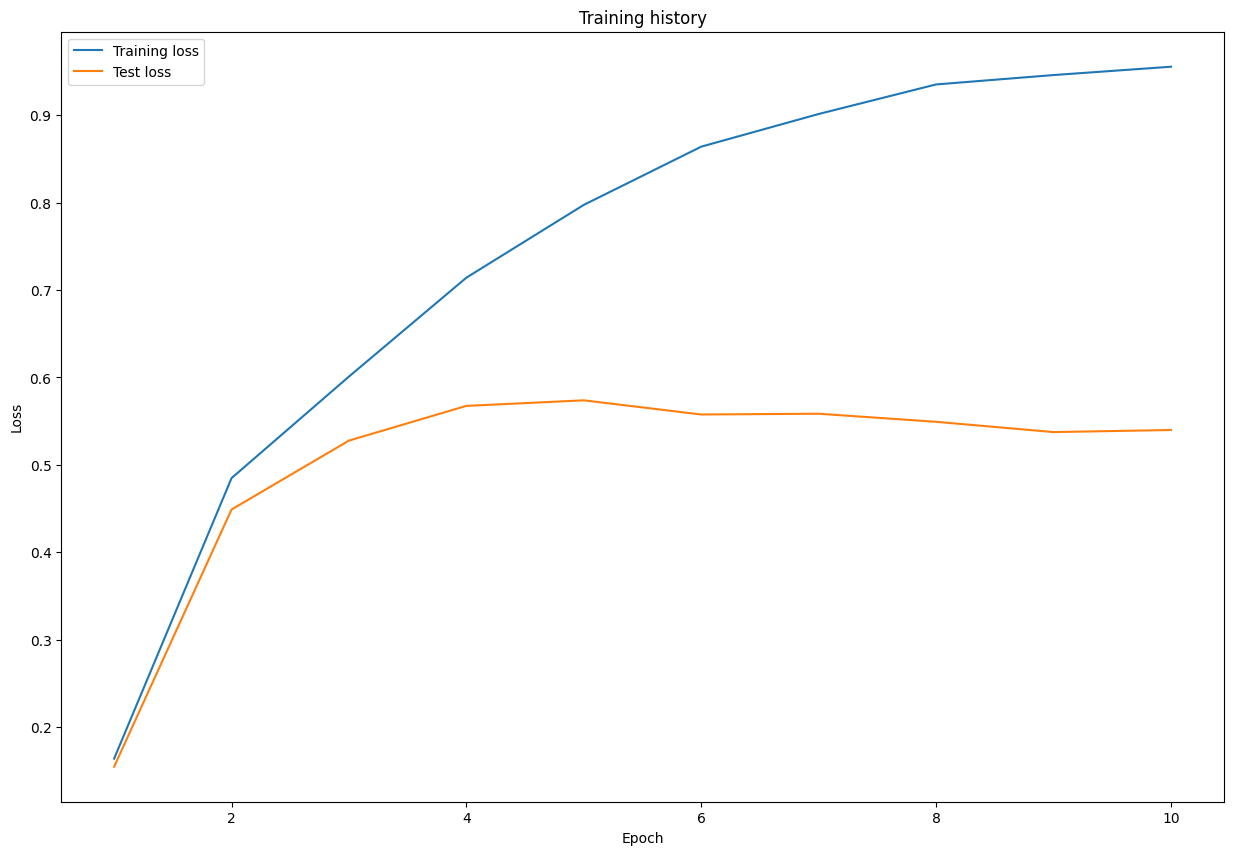

In [41]:
#Plotting the training and test accuracy per epoch

plt.figure(figsize=(15,10))
plt.plot(range(1,epochs+1),f1_score_train_history,label='Training loss')
plt.plot(range(1,epochs+1),f1_score_history,label='Test loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [42]:
#creating a BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(labels_ids),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      hidden_dropout_prob=0.1)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [43]:
#Loading the model we saved in a file
model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))

<All keys matched successfully>

In [44]:
#Getting the predictions and the types of the users in the test set
_, predictions, true_vals = evaluate(dataloader_test)

In [45]:
#Getting the accuracy per class of each personality type
y_preds, y_true = accuracy_per_class(predictions, true_vals)

Class: ISTJ
Accuracy: 16/31

Class: ISFJ
Accuracy: 14/25

Class: INFJ
Accuracy: 122/221

Class: INTJ
Accuracy: 89/164

Class: ISTP
Accuracy: 25/50

Class: ISFP
Accuracy: 22/41

Class: INFP
Accuracy: 198/275

Class: INTP
Accuracy: 124/196

Class: ESTP
Accuracy: 2/13

Class: ESFP
Accuracy: 0/7

Class: ENFP
Accuracy: 55/101

Class: ENTP
Accuracy: 58/103

Class: ESTJ
Accuracy: 0/6

Class: ESFJ
Accuracy: 0/6

Class: ENFJ
Accuracy: 10/28

Class: ENTJ
Accuracy: 13/35



              precision    recall  f1-score   support

        ISTJ       0.50      0.52      0.51        31
        ISFJ       0.67      0.56      0.61        25
        INFJ       0.60      0.55      0.58       221
        INTJ       0.55      0.54      0.55       164
        ISTP       0.51      0.50      0.51        50
        ISFP       0.39      0.54      0.45        41
        INFP       0.62      0.72      0.67       275
        INTP       0.60      0.63      0.62       196
        ESTP       0.25      0.15      0.19        13
        ESFP       1.00      0.00      0.00         7
        ENFP       0.53      0.54      0.54       101
        ENTP       0.54      0.56      0.55       103
        ESTJ       1.00      0.00      0.00         6
        ESFJ       1.00      0.00      0.00         6
        ENFJ       0.67      0.36      0.47        28
        ENTJ       0.68      0.37      0.48        35

    accuracy                           0.57      1302
   macro avg       0.63   

<ipython-input-46-8badd431bf55>:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_mat = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


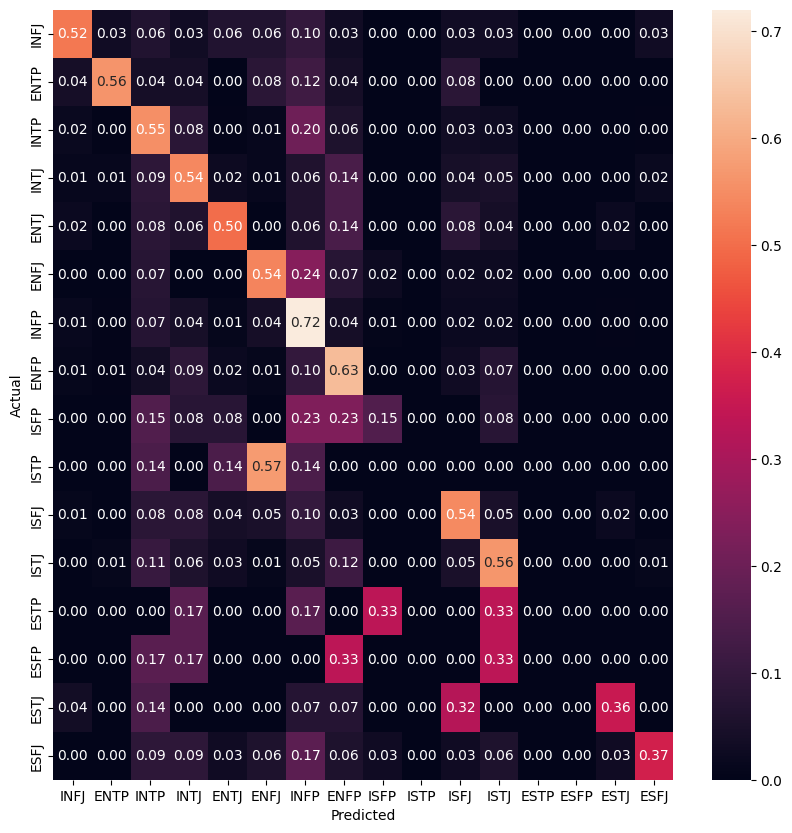

In [46]:
#Plotting the confusion matrix in order to identifiy the misclassified types
import seaborn as sns
from sklearn import metrics
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(20,10))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Type')
  plt.xlabel('Predicted Type');

# classification_report 계산
evaluation_report = metrics.classification_report(y_true, y_preds, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()), zero_division=1)

print(evaluation_report)
# evaluation_report = metrics.classification_report(true_vals, predictions, labels=labels2, target_names=labels2, zero_division=1)
# # Show the evaluation report.
# print(evaluation_report)

cm = metrics.confusion_matrix(y_true, y_preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
conf_mat = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()